In [2]:
from pathlib import Path
from tqdm.notebook import tqdm
import librosa
import librosa.display
import numpy as np
import soundfile
import pandas as pd
import joblib

import random
import os

## Parameters
Let's introduce a few convenience variables.

In [3]:
SR = 32_000
DURATION = 5
SEED = 42

In [10]:
PATH_DATASET = Path("../input/birdclef-2021/")
PATH_DATASET.exists()

True

In [11]:
L_birds = [path.name for path
           in (PATH_DATASET / "train_short_audio").iterdir()]
L_birds[:10]

['caltow',
 'canwar',
 'swathr',
 'bongul',
 'rthhum',
 'bnhcow',
 'blsspa1',
 'cobtan1',
 'thbeup1',
 'bkmtou1']

In [12]:
L_sorted = sorted(L_birds)
if L_birds != L_sorted:
    print("False")
    L_birds = L_sorted

False


In [13]:
D_label_index = {label: i for i, label in enumerate(L_birds)}
D_label_index

{'acafly': 0,
 'acowoo': 1,
 'aldfly': 2,
 'ameavo': 3,
 'amecro': 4,
 'amegfi': 5,
 'amekes': 6,
 'amepip': 7,
 'amered': 8,
 'amerob': 9,
 'amewig': 10,
 'amtspa': 11,
 'andsol1': 12,
 'annhum': 13,
 'astfly': 14,
 'azaspi1': 15,
 'babwar': 16,
 'baleag': 17,
 'balori': 18,
 'banana': 19,
 'banswa': 20,
 'banwre1': 21,
 'barant1': 22,
 'barswa': 23,
 'batpig1': 24,
 'bawswa1': 25,
 'bawwar': 26,
 'baywre1': 27,
 'bbwduc': 28,
 'bcnher': 29,
 'belkin1': 30,
 'belvir': 31,
 'bewwre': 32,
 'bkbmag1': 33,
 'bkbplo': 34,
 'bkbwar': 35,
 'bkcchi': 36,
 'bkhgro': 37,
 'bkmtou1': 38,
 'bknsti': 39,
 'blbgra1': 40,
 'blbthr1': 41,
 'blcjay1': 42,
 'blctan1': 43,
 'blhpar1': 44,
 'blkpho': 45,
 'blsspa1': 46,
 'blugrb1': 47,
 'blujay': 48,
 'bncfly': 49,
 'bnhcow': 50,
 'bobfly1': 51,
 'bongul': 52,
 'botgra': 53,
 'brbmot1': 54,
 'brbsol1': 55,
 'brcvir1': 56,
 'brebla': 57,
 'brncre': 58,
 'brnjay': 59,
 'brnthr': 60,
 'brratt1': 61,
 'brwhaw': 62,
 'brwpar1': 63,
 'btbwar': 64,
 'btnwar': 6

In [14]:
D_index_label = {v: k for k, v in D_label_index.items()}
D_index_label

{0: 'acafly',
 1: 'acowoo',
 2: 'aldfly',
 3: 'ameavo',
 4: 'amecro',
 5: 'amegfi',
 6: 'amekes',
 7: 'amepip',
 8: 'amered',
 9: 'amerob',
 10: 'amewig',
 11: 'amtspa',
 12: 'andsol1',
 13: 'annhum',
 14: 'astfly',
 15: 'azaspi1',
 16: 'babwar',
 17: 'baleag',
 18: 'balori',
 19: 'banana',
 20: 'banswa',
 21: 'banwre1',
 22: 'barant1',
 23: 'barswa',
 24: 'batpig1',
 25: 'bawswa1',
 26: 'bawwar',
 27: 'baywre1',
 28: 'bbwduc',
 29: 'bcnher',
 30: 'belkin1',
 31: 'belvir',
 32: 'bewwre',
 33: 'bkbmag1',
 34: 'bkbplo',
 35: 'bkbwar',
 36: 'bkcchi',
 37: 'bkhgro',
 38: 'bkmtou1',
 39: 'bknsti',
 40: 'blbgra1',
 41: 'blbthr1',
 42: 'blcjay1',
 43: 'blctan1',
 44: 'blhpar1',
 45: 'blkpho',
 46: 'blsspa1',
 47: 'blugrb1',
 48: 'blujay',
 49: 'bncfly',
 50: 'bnhcow',
 51: 'bobfly1',
 52: 'bongul',
 53: 'botgra',
 54: 'brbmot1',
 55: 'brbsol1',
 56: 'brcvir1',
 57: 'brebla',
 58: 'brncre',
 59: 'brnjay',
 60: 'brnthr',
 61: 'brratt1',
 62: 'brwhaw',
 63: 'brwpar1',
 64: 'btbwar',
 65: 'btnwar

## Melspectrogram
Let's study how to cut the audio files into pieces of 5 sec each and transform them into melspectrogram.

In [15]:
class MelSpecComputer:
    def __init__(self, sr, n_mels, fmin, fmax, **kwargs):
        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax
        kwargs["n_fft"] = kwargs.get("n_fft", self.sr//10)
        kwargs["hop_length"] = kwargs.get("hop_length", self.sr//(10*4))
        self.kwargs = kwargs

    def __call__(self, y):
        melspec = librosa.feature.melspectrogram(
            y,
            sr=self.sr,
            n_mels=self.n_mels,
            fmin=self.fmin,
            fmax=self.fmax,
            **self.kwargs,
        )

        melspec = librosa.power_to_db(melspec).astype(np.float32)
        return melspec

In [16]:
def standardize_uint8(X, eps=1e-6, mean=None, std=None):
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    
    min_, max_ = X.min(), X.max()
    if max_ - min_ > eps:
        #V = np.clip(X, min_, max_)
        #V = 255 * (V - min_) / (max_ - min_)
        V = 255 * (X - min_) / (max_ - min_)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)
    return V

def crop_or_pad(y, length, is_train=True, start=None):
    """
    crop or pad the signal y to #(samples) = `length`
      - repetition of itself
      - random truncating
    """
    if len(y) < length:
        #y = np.concatenate([y, np.zeros(length - len(y))])
        n_repeats = length // len(y)
        remainder = length % len(y)
        y = np.concatenate([y]*n_repeats + [y[:remainder]])
    elif len(y) > length:
        if not is_train:
            start = start or 0
        else:
            start = start or np.random.randint(len(y) - length)
        y = y[start:start + length]
    return y

In [17]:
path_random_short_audio = random.choice(
    list((PATH_DATASET / "train_short_audio").glob("*/*.ogg"))
)
print(f"path_random_short_audio =\n{path_random_short_audio}")


# Excerpt from `class AudioToImage`
audio, orig_sr = soundfile.read(path_random_short_audio, dtype="float32")

if orig_sr != SR:
    audio = librosa.resample(audio, orig_sr, SR, res_type="kaiser_fast")

audio = crop_or_pad(audio, length=SR*DURATION)
mel_spec_computer = MelSpecComputer(
    sr=SR,
    n_mels=128,
    fmin=0,
    fmax=None,
)
melspec = mel_spec_computer(audio) 
image = standardize_uint8(melspec)
type(image), image.shape

path_random_short_audio =
../input/birdclef-2021/train_short_audio/swathr/XC177489.ogg


(numpy.ndarray, (128, 201))

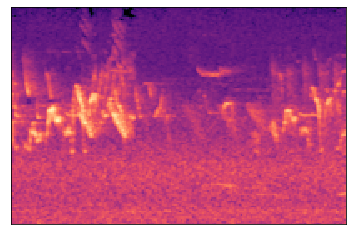

In [18]:
librosa.display.specshow(image);

These melspectrograms seem to be all single-channeled. Besides, probably due to the fact we have always taken the same number of samples (after resampling with a common `SR`), we always obtain an ndarray of shape `(128, 201)`.

## Statistics on `train_short_audio/`
I would like to know some statistics like

- How many `.ogg` files does each bird label have?
  - Linux's `tree` command might be able to answer to this question.
- How long are these `.ogg` files? Are some a lot longer than others?

Well, if we are to use `tree`, we'd be better off writing a whole shell script. Let's try it Python way.

In [19]:
PATH_DATASET.stat()

os.stat_result(st_mode=16877, st_ino=1129894951, st_dev=56, st_nlink=5, st_uid=65534, st_gid=65534, st_size=0, st_atime=1616604982, st_mtime=1616605097, st_ctime=1616605097)

In [20]:
PATH_DATASET.stat().st_size

0

In [21]:
len(list(PATH_DATASET.iterdir()))

7

`st_size` is the size of the file, i.e. how many bytes.

In [22]:
!ls -ld $PATH_DATASET

drwxr-xr-x 5 nobody nogroup 0 Mar 24 16:58 ../input/birdclef-2021


In [23]:
D_label_nShort = dict()

In [24]:
for p in (PATH_DATASET / "train_short_audio").iterdir():
    n_oggs = len(set(p.iterdir()))
    print(f"{p.name:12s}{n_oggs: 5d}")
    D_label_nShort[p.name] = n_oggs

caltow         89
canwar        126
swathr        450
bongul         53
rthhum         34
bnhcow        177
blsspa1       111
cobtan1       184
thbeup1       104
bkmtou1       153
plsvir        141
rufhum         64
botgra         84
yetvir        107
amerob        481
linwoo1       174
mouwar        127
whfpar1        79
weskin        101
bkbwar        111
yebsee1        95
brwpar1        45
mouela1       102
brwhaw         67
sinwre1       108
blujay        328
leasan         62
gocspa         85
monoro1        64
higmot1        46
tropar        173
brnthr        149
grethr1       165
lucwar         80
lesgol        227
sumtan        210
moudov        120
grbani         94
orbeup1       148
dusfly        113
solsan         78
saypho         81
laugul         66
burwar1       159
thbkin         93
gcrwar        181
cogdov         70
rutjac1       142
caster1       144
yehcar1       126
yebsap         63
whwbec1       133
whiwre1       148
melbla1        81
cliswa         95
chbant1   

In [25]:
def duration(path_ogg):
    audio, orig_sr = soundfile.read(path_ogg, dtype="float32")
    audio = librosa.resample(audio, orig_sr, SR, res_type="kaiser_fast")
    return len(audio) / SR

The following cell can display the number of seconds each `.ogg` file lasts, but it's **time-consuming**; we'd better combine it with other loops for reading all the short audio files.
> But the result show that the duration is not quite homogeneous: it could range from as low as 6 seconds to sth like 200 seconds.

## `train_soundscapes/`

In [26]:
df_train_soundscape = pd.read_csv(PATH_DATASET/"train_soundscape_labels.csv")
df_train_soundscape.head()

,row_id,site,audio_id,seconds,birds
0,7019_COR_5,COR,7019,5,nocall
1,7019_COR_10,COR,7019,10,nocall
2,7019_COR_15,COR,7019,15,nocall
3,7019_COR_20,COR,7019,20,nocall
4,7019_COR_25,COR,7019,25,nocall


There are a total of `20` `.ogg` files in `train_soundscapes/`: I would like to split these into train/val/test sets.

- `12` files for train
- `4` files for val
- `4` files for test

### Nota Bene
Just be careful: We decided to split the training data given by Kaggle into 3 parts -- train/val/test. So the word **`train`** in what follows may

- either means `train-train`
- or just `train`

Sorry for the confusion and the abuse, but unless I find time or I wouldn't correct it.

In [27]:
n_train = 12
n_val = 4     # Maybe I will put train and val together
n_test = 4

In [28]:
test_size = n_test / sum([n_test, n_train, n_val])
test_size

0.2

In [29]:
L_paths_train_soundscape     = sorted(list((PATH_DATASET / "train_soundscapes").iterdir()))
L_paths_train_soundscape_SSW = sorted(list((PATH_DATASET / "train_soundscapes").glob("*SSW*.ogg")))
L_paths_train_soundscape_COR = sorted(list((PATH_DATASET / "train_soundscapes").glob("*COR*.ogg")))
[ p.name for p in L_paths_train_soundscape ]

['10534_SSW_20170429.ogg',
 '11254_COR_20190904.ogg',
 '14473_SSW_20170701.ogg',
 '18003_COR_20190904.ogg',
 '20152_SSW_20170805.ogg',
 '21767_COR_20190904.ogg',
 '26709_SSW_20170701.ogg',
 '26746_COR_20191004.ogg',
 '2782_SSW_20170701.ogg',
 '28933_SSW_20170408.ogg',
 '31928_COR_20191004.ogg',
 '42907_SSW_20170708.ogg',
 '44957_COR_20190923.ogg',
 '50878_COR_20191004.ogg',
 '51010_SSW_20170513.ogg',
 '54955_SSW_20170617.ogg',
 '57610_COR_20190904.ogg',
 '7019_COR_20190904.ogg',
 '7843_SSW_20170325.ogg',
 '7954_COR_20190923.ogg']

In [30]:
from sklearn.model_selection import train_test_split

L_SSW_IDs = [int(p.name.split("_")[0]) for p in L_paths_train_soundscape_SSW]
L_COR_IDs = [int(p.name.split("_")[0]) for p in L_paths_train_soundscape_COR]

L_trainSoundScape_SSW_IDs, L_testSoundScape_SSW_IDs, L_trainSoundScape_COR_IDs, L_testSoundScape_COR_IDs = train_test_split(
    L_SSW_IDs, L_COR_IDs, test_size=test_size, random_state=SEED)

print(f"L_trainSoundScape_SSW_IDs = {L_trainSoundScape_SSW_IDs}")
print(f"L_testSoundScape_SSW_IDs = {L_testSoundScape_SSW_IDs}")
print(f"L_trainSoundScape_COR_IDs = {L_trainSoundScape_COR_IDs}")
print(f"L_testSoundScape_COR_IDs = {L_testSoundScape_COR_IDs}")

L_trainSoundScape_SSW_IDs = [28933, 10534, 51010, 20152, 7843, 2782, 26709, 42907]
L_testSoundScape_SSW_IDs = [54955, 14473]
L_trainSoundScape_COR_IDs = [44957, 11254, 57610, 21767, 7954, 31928, 26746, 50878]
L_testSoundScape_COR_IDs = [7019, 18003]


In [31]:
L_trainSoundScapeIDs = L_trainSoundScape_SSW_IDs + L_trainSoundScape_COR_IDs
L_testSoundScapeIDs = L_testSoundScape_SSW_IDs + L_testSoundScape_COR_IDs
S_trainSoundScapeIDs = set(L_trainSoundScapeIDs)
S_testSoundScapeIDs = set(L_testSoundScapeIDs)
print(f"S_trainSoundScapeIDs = {S_trainSoundScapeIDs}")
print(f"S_testSoundScapeIDs = {S_testSoundScapeIDs}")

S_trainSoundScapeIDs = {51010, 7843, 28933, 10534, 21767, 57610, 50878, 7954, 26709, 11254, 31928, 20152, 26746, 42907, 44957, 2782}
S_testSoundScapeIDs = {14473, 18003, 54955, 7019}


In [32]:
df_train_soundscape["is_test"] = [ (id_ in S_testSoundScapeIDs)
                                  for id_ in df_train_soundscape.audio_id]
df_train_soundscape.head()

,row_id,site,audio_id,seconds,birds,is_test
0,7019_COR_5,COR,7019,5,nocall,True
1,7019_COR_10,COR,7019,10,nocall,True
2,7019_COR_15,COR,7019,15,nocall,True
3,7019_COR_20,COR,7019,20,nocall,True
4,7019_COR_25,COR,7019,25,nocall,True


`mkdir` for places to store melspectrogram `.npy` files

In [33]:
trainSoundScapes = Path("./trainSoundScapes")
trainSoundScapes.exists()

False

In [34]:
trainSoundScapes.mkdir(exist_ok=True)
trainSoundScapes.exists()

True

In [35]:
testSoundScapes = Path("./testSoundScapes")
testSoundScapes.exists()

False

In [36]:
testSoundScapes.mkdir(exist_ok=True)
testSoundScapes.exists()

True

In [37]:
ls

__notebook_source__.ipynb  testSoundScapes/  trainSoundScapes/


`NamedTuple` and `itertuples()` method from dataframe

### So Wrong
There are a few drawbacks in the previous two cells:
- It was wrong by saving all `.npy` files to `trainSoundScape` directory: Some should be saved to `testSoundScape` directory.
- It is not sufficient because the same `.ogg` file is opened and read several times.
  - Write a function or a class of your own and stop using kkiller's in this case.

### Objectives: Save `.npy` Files
Let's make our objectives clear.

01. We want to save each `train_soundscapes/` audio file, each 5-sec clip, to an `.npy` file.
  - The file reading and melspectrogram transform might be quite blocking, so **asynchronous** or **multi-process** (e.g. `concurrent.futures.ProcessPoolExecutor` or `joblib`) programming might be useful here.
02. We want to update `df_train_soundscape` to contain more information. What information?
  - Date: Can be separated.
  - Corresponding `.npy` path: Can be separated.
  - Longitude, latitude: Can be separated.
  
Since the two objectives above can be separated, and updating an extra dataframe while saving `.npy` for each `.ogg` file can become quite complicated, let's first get objective 1 done and start objective 2 after that.

### Objective 1: `.ogg` to `.npy`

#### `joblib` way

In [38]:
def audio_to_mels(audio,
                  sr=SR,
                  n_mels=128,
                  fmin=0,
                  fmax=None):
    fmax = fmax or sr // 2
    mel_spec_computer = MelSpecComputer(sr=sr,
                                        n_mels=n_mels,
                                        fmin=fmin,
                                        fmax=fmax)
    mels = standardize_uint8(mel_spec_computer(audio))
    return mels

def every_5sec(id_,
               sr=SR,
               resample=True,
               res_type="kaiser_fast",
               single_process=True,
               save_to=Path("corbeille"),
               n_workers=2
                ):
    """
    - read the audio file of ID `id_`
    - cut the read audio into pieces of 5 seconds
    - convert each piece into `.npy` file and save
    """
    path_ogg = next((PATH_DATASET / "train_soundscapes").glob(f"{id_}*.ogg"))
    location = (path_ogg.name).split("_")[1]
    whole_audio, orig_sr = soundfile.read(path_ogg, dtype="float32")
    if resample and orig_sr != sr:
        whole_audio = librosa.resample(whole_audio, orig_sr, sr, res_type=res_type)
    n_samples = len(whole_audio)
    n_samples_5sec = sr * 5
    save_to.mkdir(exist_ok=True)

    def convert_and_save(i):
        audio_i = whole_audio[i:i + n_samples_5sec]
        mels_i = audio_to_mels(audio_i)
        path_i = save_to / f"{id_}_{location}_{((i + n_samples_5sec) // n_samples_5sec) * 5}.npy"
        np.save(str(path_i), mels_i)

    if single_process:
        for i in range(0, n_samples - n_samples % n_samples_5sec, n_samples_5sec):
            #audio_i = whole_audio[i:i + n_samples_5sec]
            ## No need the next check because in range() we have subtracted the remainder.
            ## That is, len(audio_i) is guaranteed to be n_samples_5sec for all i.
            ##if len(audio_i) < n_samples_5sec:
            ##    pass
            #mels_i = audio_to_mels(audio_i)
            #path_i = save_to / f"{id_}_{location}_{((i + n_samples_5sec) // n_samples_5sec) * 5}.npy"
            #np.save(str(path_i), mels_i)
            convert_and_save(i)
    else:
        pool = joblib.Parallel(n_workers)
        mapping = joblib.delayed(convert_and_save)
        tasks = (mapping(i) for i in range(0, n_samples - n_samples % n_samples_5sec, n_samples_5sec))
        pool(tasks)

def soundscapes_to_npy(is_test=False, n_processes=4):
    pool = joblib.Parallel(n_processes)
    mapping = joblib.delayed(every_5sec)
    if is_test:
        tasks = list(mapping(id_, save_to=testSoundScapes) for id_ in S_testSoundScapeIDs)
        #tasks = list(mapping(id_,
        #                     single_process=False,
        #                     save_to=testSoundScapes)
        #             for id_ in S_testSoundScapeIDs)
    else:
        tasks = list(mapping(id_, save_to=trainSoundScapes) for id_ in S_trainSoundScapeIDs)
        #tasks = list(mapping(id_,
        #                     single_process=False,
        #                     save_to=trainSoundScapes)
        #             for id_ in S_trainSoundScapeIDs)
    pool(tqdm(tasks))

### Nota Bene
- `tasks` (i.e. input to `joblib.Parallel`) can be either a generator or a list, but since I do not know a priori the length of a generator, when combined with the usage of `tqdm`, the progress bar will lack the capability to show progress percentage, compared to using a list.

In [39]:
%%time
soundscapes_to_npy()

  0%|          | 0/16 [00:00<?, ?it/s]

CPU times: user 249 ms, sys: 55 ms, total: 304 ms
Wall time: 19.1 s


In [40]:
soundscapes_to_npy(is_test=True)

  0%|          | 0/4 [00:00<?, ?it/s]

In [41]:
S_testSoundScapeIDs

{7019, 14473, 18003, 54955}

In [42]:
!ls $trainSoundScapes | wc -l

1920


In [43]:
!ls $testSoundScapes | wc -l

480


In [44]:
16 * (600 // 5)

1920

In [45]:
4 * (600 // 5)

480

Let's at least verify that the saved images exhibit difference.<br>
Try execute the next cell several times to see randomly the melspectrograms.

rand_npy = 11254_COR_185.npy


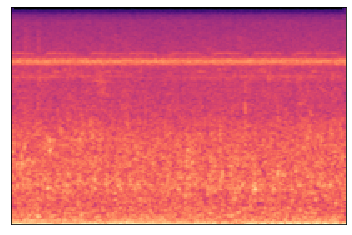

In [52]:
rand_npy = random.choice(list(trainSoundScapes.iterdir()))
rand_image = np.load(rand_npy)
print(f"rand_npy = {rand_npy.name}")
librosa.display.specshow(rand_image);

### Objective 2: Construct `df_train_soundscape`

Recall that
> - We want to update `df_train_soundscape` to contain more information. What information?
>   - Date: Can be separated.
>   - Corresponding `.npy` path: Can be separated.
>   - Longitude, latitude: Can be separated.
>   - birds label to birds indices?
>   - new col `"n_birds"` and do a stat?

Construct a dictionary for

- key: recording location, e.g. `COR`, `SSW`, etc.
- value: possibly `NamedTuple(longitude, latitude)`

In [53]:
from collections import namedtuple
Coordinate = namedtuple("Coordinate", ["longitude", "latitude"])

D_location_coordinate = dict()
for p in (PATH_DATASET / "test_soundscapes").glob("*_recording_location.txt"):
    location = p.stem.split("_")[0]
    with open(p) as f:
        lines = f.readlines()
        for line in lines:
            if line.startswith("Latitude:"):
                latitude = float(line.split(" ")[1])
            if line.startswith("Longitude:"):
                longitude = float(line.split(" ")[1])
    D_location_coordinate[location] = Coordinate(longitude=longitude, latitude=latitude)
D_location_coordinate

{'COR': Coordinate(longitude=-84.51, latitude=10.12),
 'COL': Coordinate(longitude=-75.85, latitude=5.57),
 'SNE': Coordinate(longitude=-119.95, latitude=38.49),
 'SSW': Coordinate(longitude=-76.45, latitude=42.47)}

I think the year won't make much difference.

In [54]:
# Randomly initialize the new columns
df_train_soundscape["year"] = -1
df_train_soundscape["month"] = -1
df_train_soundscape["day"] = -1
df_train_soundscape["longitude"] = 365.0
df_train_soundscape["latitude"] = 365.0
#df_train_soundscape["npy_path"] = None
df_train_soundscape.head()

,row_id,site,audio_id,seconds,birds,is_test,year,month,day,longitude,latitude
0,7019_COR_5,COR,7019,5,nocall,True,-1,-1,-1,365.0,365.0
1,7019_COR_10,COR,7019,10,nocall,True,-1,-1,-1,365.0,365.0
2,7019_COR_15,COR,7019,15,nocall,True,-1,-1,-1,365.0,365.0
3,7019_COR_20,COR,7019,20,nocall,True,-1,-1,-1,365.0,365.0
4,7019_COR_25,COR,7019,25,nocall,True,-1,-1,-1,365.0,365.0


In [55]:
df_train_soundscape["year"].dtype

dtype('int64')

In [56]:
df_train_soundscape["longitude"].dtype

dtype('float64')

In [57]:
for p in (PATH_DATASET / "train_soundscapes").iterdir():
    id_, location, date = p.stem.split("_")
    # date, str, "yyyymmdd"
    year = int(date[:4])
    month = int(date[4:6])
    day = int(date[6:])
    id_ = int(id_)
    filter_ = df_train_soundscape.audio_id == id_
    #df_train_soundscape.loc[filter_, ["year"]] = year
    #df_train_soundscape.loc[filter_, ["month"]] = month
    #df_train_soundscape.loc[filter_, ["day"]] = day
    df_train_soundscape.loc[filter_, "year"] = year
    df_train_soundscape.loc[filter_, "month"] = month
    df_train_soundscape.loc[filter_, "day"] = day
    #is_test = id_ in S_testSoundScapeIDs
df_train_soundscape

,row_id,site,audio_id,seconds,birds,is_test,year,month,day,longitude,latitude
0,7019_COR_5,COR,7019,5,nocall,True,2019,9,4,365.0,365.0
1,7019_COR_10,COR,7019,10,nocall,True,2019,9,4,365.0,365.0
2,7019_COR_15,COR,7019,15,nocall,True,2019,9,4,365.0,365.0
3,7019_COR_20,COR,7019,20,nocall,True,2019,9,4,365.0,365.0
4,7019_COR_25,COR,7019,25,nocall,True,2019,9,4,365.0,365.0
...,...,...,...,...,...,...,...,...,...,...,...
2395,54955_SSW_580,SSW,54955,580,nocall,True,2017,6,17,365.0,365.0
2396,54955_SSW_585,SSW,54955,585,grycat,True,2017,6,17,365.0,365.0
2397,54955_SSW_590,SSW,54955,590,grycat,True,2017,6,17,365.0,365.0
2398,54955_SSW_595,SSW,54955,595,nocall,True,2017,6,17,365.0,365.0


We use string concatenation for the construction of the column `"npy_path"`.

In [58]:
str(PATH_DATASET)

'../input/birdclef-2021'

In [59]:
df_train_soundscape["npy_parent"] = ""
is_test = df_train_soundscape.is_test == True
is_train = ~is_test
df_train_soundscape.loc[is_test, "npy_parent"] = str(testSoundScapes)
df_train_soundscape.loc[is_train, "npy_parent"] = str(trainSoundScapes)
df_train_soundscape.loc[is_train].head()

,row_id,site,audio_id,seconds,birds,is_test,year,month,day,longitude,latitude,npy_parent
120,7954_COR_5,COR,7954,5,nocall,False,2019,9,23,365.0,365.0,trainSoundScapes
121,7954_COR_10,COR,7954,10,nocall,False,2019,9,23,365.0,365.0,trainSoundScapes
122,7954_COR_15,COR,7954,15,nocall,False,2019,9,23,365.0,365.0,trainSoundScapes
123,7954_COR_20,COR,7954,20,nocall,False,2019,9,23,365.0,365.0,trainSoundScapes
124,7954_COR_25,COR,7954,25,nocall,False,2019,9,23,365.0,365.0,trainSoundScapes


In [60]:
df_train_soundscape["npy_path"] = \
    df_train_soundscape["npy_parent"] + "/" + \
    df_train_soundscape["row_id"] + ".npy"

# or equiv.
#df_train_soundscape.loc[:, "npy_path"] = \
#    df_train_soundscape.loc[:, "npy_parent"] + "/" + \
#    df_train_soundscape.loc[:, "row_id"] + ".npy"

In [61]:
df_train_soundscape.loc[is_test, ["row_id", "npy_path"]]

,row_id,npy_path
0,7019_COR_5,testSoundScapes/7019_COR_5.npy
1,7019_COR_10,testSoundScapes/7019_COR_10.npy
2,7019_COR_15,testSoundScapes/7019_COR_15.npy
3,7019_COR_20,testSoundScapes/7019_COR_20.npy
4,7019_COR_25,testSoundScapes/7019_COR_25.npy
...,...,...
2395,54955_SSW_580,testSoundScapes/54955_SSW_580.npy
2396,54955_SSW_585,testSoundScapes/54955_SSW_585.npy
2397,54955_SSW_590,testSoundScapes/54955_SSW_590.npy
2398,54955_SSW_595,testSoundScapes/54955_SSW_595.npy


In [62]:
df_train_soundscape.loc[is_train, ["row_id", "npy_path"]]

,row_id,npy_path
120,7954_COR_5,trainSoundScapes/7954_COR_5.npy
121,7954_COR_10,trainSoundScapes/7954_COR_10.npy
122,7954_COR_15,trainSoundScapes/7954_COR_15.npy
123,7954_COR_20,trainSoundScapes/7954_COR_20.npy
124,7954_COR_25,trainSoundScapes/7954_COR_25.npy
...,...,...
2275,51010_SSW_580,trainSoundScapes/51010_SSW_580.npy
2276,51010_SSW_585,trainSoundScapes/51010_SSW_585.npy
2277,51010_SSW_590,trainSoundScapes/51010_SSW_590.npy
2278,51010_SSW_595,trainSoundScapes/51010_SSW_595.npy


For the columns `"longitude", "latitude"`, we will loop thru `D_location_coordinate`.

In [63]:
D_location_coordinate

{'COR': Coordinate(longitude=-84.51, latitude=10.12),
 'COL': Coordinate(longitude=-75.85, latitude=5.57),
 'SNE': Coordinate(longitude=-119.95, latitude=38.49),
 'SSW': Coordinate(longitude=-76.45, latitude=42.47)}

In [64]:
lo, la = D_location_coordinate["COR"]
lo, la

(-84.51, 10.12)

In [65]:
for location, coordinate in D_location_coordinate.items():
    lo, la= coordinate.longitude, coordinate.latitude
    location_filter = df_train_soundscape.loc[:, "site"] == location
    df_train_soundscape.loc[location_filter, "longitude"] = lo
    df_train_soundscape.loc[location_filter, "latitude"] = la
df_train_soundscape.loc[:, ["site", "longitude", "latitude"]]

,site,longitude,latitude
0,COR,-84.51,10.12
1,COR,-84.51,10.12
2,COR,-84.51,10.12
3,COR,-84.51,10.12
4,COR,-84.51,10.12
...,...,...,...
2395,SSW,-76.45,42.47
2396,SSW,-76.45,42.47
2397,SSW,-76.45,42.47
2398,SSW,-76.45,42.47


In [66]:
def birds_to_ndarry(series):
    I = np.eye(len(D_label_index))
    ndarray = np.zeros((len(series), len(D_label_index)))
    for i, string in enumerate(series.values):
        if string == "nocall":
            continue
        else:
            L_indices = [D_label_index[label] for label in string.split(" ")]
            row_i = np.sum(I[L_indices], axis=0)
            ndarray[i] = row_i
    return ndarray

In [67]:
A = birds_to_ndarry(df_train_soundscape.birds)
A.shape

(2400, 397)

In [68]:
y_train = A[df_train_soundscape.is_test==False]
y_train.shape

(1920, 397)

In [69]:
y_test = A[df_train_soundscape.is_test==True]
y_test.shape

(480, 397)

In [70]:
#df_train_soundscape.to_csv("rich_train_soundscape_labels.csv", index=True)
df_train_soundscape.to_csv("rich_train_soundscape_labels.csv", index=False)